In [2]:
## fetch the data 

import os
import tarfile
import urllib

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_data(fetch_url = HOUSING_URL , fetch_path = HOUSING_PATH):
    os.makedirs( fetch_path , exist_ok = True)
    tgz_path = os.path.join(fetch_path ,"housing.tgz")
    urllib.request.urlretrieve(fetch_url , tgz_path)
    data_tgz = tarfile.open(tgz_path)
    data_tgz.extractall(path= fetch_path)
    data_tgz.close()

fetch_data()

In [3]:
import pandas as pd

def load_housing_data(housing_path = HOUSING_PATH):
    csv_file_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_file_path)

data=load_housing_data()

In [4]:
## Eye data lookup
data.head()
data.info()
## well there we have the ocean_proximity here is a categorical attribute
data['ocean_proximity'].value_counts()

## get some stat about the data
data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


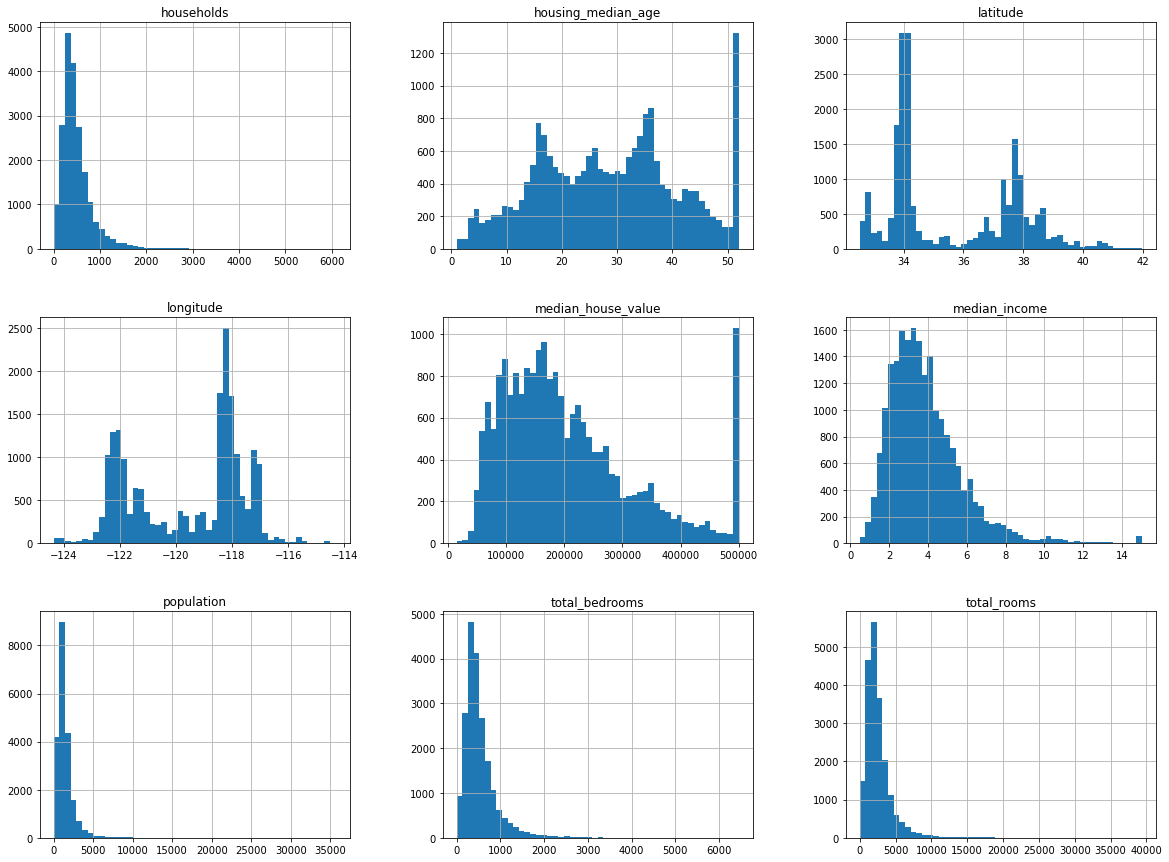

In [5]:
## to have another feel of the type of data we have create histogram for the numerical attr.
%matplotlib inline
import matplotlib.pyplot as plt
data.hist(bins= 50 , figsize= (20 , 15))
plt.show()
## from these histograms important information can be gathered\
## - it is clear that multiple features have their values capped ,median income for example( though not really significant and
## will not make huge effect but good to know that) , however housing median age and median housing value ( the labeled attribute)
## is capped for a max of 500k , this is a major drawback in the distribution of data as a false pattern will be learnt that 
## there is over 1K discricts with 500K median house value which is indeed not true.
## to handle this you can either ignore any values that are greater than 500K or ask the busniess owners if it is ok that 500K+ will 
## not be as accurate as the whole model

## another thing to observe is that gausiian distributions are not perfect they are skewed towards the the end of the axis this 
## could be tackled in the future.

In [6]:
## train test splitting
from sklearn.model_selection import train_test_split
import numpy as np

## well , this is probably one of the simplist thing that someone can think of while makeing his ML model - just splitting the data.
## it is indeed simple but small details that many people ignore can lead easily to significant sampling bias
## if you are creating a survey about how challenging an engineering degree is , it would be dump if you asked people with an
## avg GPA less than 3 only , just as dump if you are asking students that only got a 3.8+. you need to check how is the GPAs distibuted
## and accordingly decide how many students if each sector you will be asking if 15% scored 3.8+ and 60% scored 3+ 3.8- and the rest 
## were less than a 3 then if you are asking 100 students you need to maintain the same ratios. 
## this is just the same thing when you are samplign your data you dont want a training test with many of any value you just wwant 
## the natural amount of every value. Well in this case it is the income attribute( you don't want more
## wealthy people or more poor ones you want the real dist) that we want to wisly split it
## being a numerical attribute makes this quite challenging we neeed to categorize the data first.
## you can choose the amount of buckets flexibly here 5, 6 or 7 should be enough to represent the data.
data["income_cat"] = pd.cut(data['median_income'], bins=[0, 1.5, 3.0,4.5,6,np.inf], labels = [1 ,2,3,4,5])

train_set , test_set = train_test_split(data , test_size=0.2 , random_state = 42)


In [7]:
## next lets see the original dist of the data
print(data["income_cat"].value_counts()*100 / len(data)) 

print(test_set["income_cat"].value_counts()*100 / len(test_set))
## this data is 20K rows so it might be deciptive to say that percentages are near some values are far by 1% which is great
## now lets try the so called Stratified approach 
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits = 1 , test_size = 0.2 , random_state = 42)
for train_index , test_index in split.split(data , data["income_cat"]):
    train_setStra = data.loc[train_index]
    test_setStra = data.loc[test_index]

print(test_setStra["income_cat"].value_counts()*100 / len(test_set))
## it could be seen that this gives way better results, now remove the extra column
for set_ in ( train_setStra , test_setStra):
    set_.drop("income_cat" , axis=1 , inplace = True)

3    35.058140
2    31.884690
4    17.630814
5    11.443798
1     3.982558
Name: income_cat, dtype: float64
3    35.852713
2    32.437016
4    16.739341
5    10.949612
1     4.021318
Name: income_cat, dtype: float64
3    35.053295
2    31.879845
4    17.635659
5    11.458333
1     3.972868
Name: income_cat, dtype: float64


In [8]:
## Now it is time to make some data visualizations to grasp the correlations between the features , it is usually a good practice
## to work on a copy of the data , if data is Big get some portions of it
## MAKE SURE FROM THIS POINT YOU NEVER LOOK AT THE TEST SET YOUR BRAIN IS WIDLY OPEN TO OVERFITTING IT MUST BE KEPT UNSEEN

train_copy = train_setStra.copy()

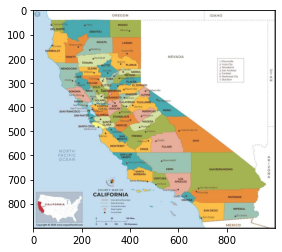

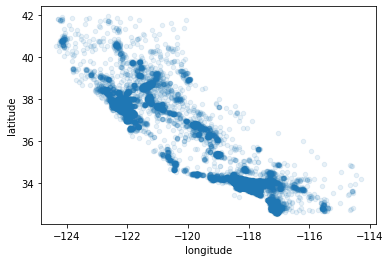

In [9]:
## well lets see the geographical data and how is the districts distributes ( costal ones seem to be very dense)
## alpha param is importnat to see the density of points try removing it to get this 
## why we do this , well it turns out that our brains are super powerful in spotting patterns in images
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img = mpimg.imread('imgs/cal.jpg')
imgplot = plt.imshow(img)
train_copy.plot(kind='scatter' , x='longitude' , y='latitude' , alpha=0.1)

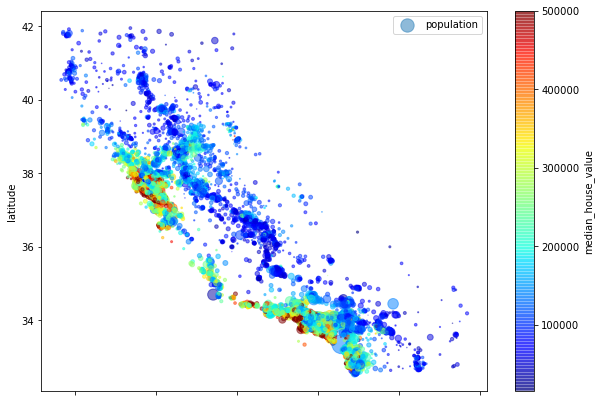

In [10]:
## after validating the user geographical points against the map of california lets check how the population and median house values 
## are corrlelated but first lets visualize it 
## s: circle radius , c= circle color
## here the radius of the circle corresponds to the populatiion 
## and the colir corresponds to the median housing value
## it is very clear that costal regions are more reddish and that's expected beach houses are not cheap!
## and also population there is higher than many others areas , though this is not the case with the northren coastal part

train_copy.plot(kind='scatter' , x='longitude' , y='latitude' , alpha =0.5 ,
               s= train_copy['population']/100 ,label="population", figsize=(10,7) , 
               c="median_house_value" , cmap= plt.get_cmap("jet") , colorbar=True)
plt.legend()

In [11]:
## Now lets check the correlations between the attributes
## we can use pandas .corr() function given that the data we have a not too big
##  this returns a 2d array of the correlation between every pair of features
## check this link to know more about corrlations https://www.youtube.com/watch?v=4EXNedimDMs
## note that those correlations are linear.
corr_matrix = train_copy.corr()

## Now let's see how the 
corr_matrix["median_house_value"].sort_values(ascending = False)



median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002DD34F7D730>,
      dtype=object)

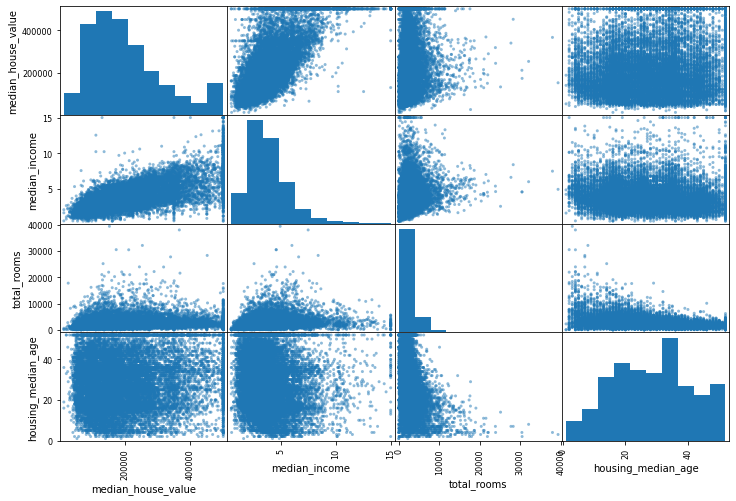

In [12]:
## as stated before our brains are better with images than with numbers 
## we can use pandas's scatter_matrix() function to plot the corrleations. here we have 11 rows so the matrix would be 11^2 plots 
## too much to fit on the screen. will foucus instead on the most important ones
from pandas.plotting import scatter_matrix
choosen = ["median_house_value" , "median_income" , "total_rooms" ,"housing_median_age"]

scatter_matrix(train_copy[choosen] , figsize=(12,8))

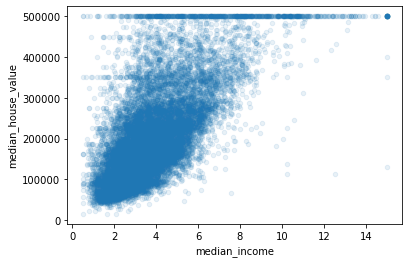

In [13]:
train_copy.plot( kind="scatter" , x="median_income" , y="median_house_value" , alpha = 0.1)

In [14]:
## feature Combination:
## Correlations allow us also to spot if any attributes need to be combined if they are not really correlated to the target label
## ex total rooms in a district is not an informative features and maybe thats why it has a low corr with the median price
## maybe if we divided this over the number of homes in the district this will be more informative.


train_copy["rooms_per_home"] = train_copy["total_rooms"]/train_copy["households"]
train_copy["bedroom_per_rooms"] = train_copy["total_bedrooms"]/train_copy["total_rooms"]
train_copy["house_population"] = train_copy["population"]/train_copy["households"]
corr_matrix = train_copy.corr()

## Now let's check the new features' corr
corr_matrix["median_house_value"].sort_values(ascending = False)

## we will add them later in the original training data when we learn about custom transformer functions that fit in a skitlearn pipeline.

median_house_value    1.000000
median_income         0.687160
rooms_per_home        0.146285
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
house_population     -0.021985
population           -0.026920
longitude            -0.047432
latitude             -0.142724
bedroom_per_rooms    -0.259984
Name: median_house_value, dtype: float64

In [15]:
## data Cleaning
## now lets get back to the original training example and separate the target value from the dataframe

X_train = train_setStra.drop("median_house_value" , axis = 1)
Y_train = train_setStra["median_house_value"].copy()

In [16]:
## dealing with missing values
## in ML we cannot have blank features so usually there are 3 ways we can deal with this
## first : simply delete the whole row ( this is ok if you have a big dataset )
## second : get rid of the whole feature ( this is more common if there are multiple nulls in the same attribute )
## third : set this nulls with a mean value or any other suitable value ( ex zero for example or median)

#X_train.dropna(subset=["total_bedrooms"]) ## option 1 
#X_train.drop("total_bedrooms" , axis = 1) ## option 2 - this is inplace
#median = X_train["total_bedrooms"].median()
#X_trian["total_bedrooms"].fillna(median , inplace=True) ## option -3

# here we will choose option three , but there is a simple function that makes all this for you ( we might need to make this for
## every ferature so it would be an overhead )
## keep in mind that sklearn's imputer don't work in categorical data so we will need to remove the "ocean proximity"
## the medians will be saved in the statistic_ variable of the imputer object , we will need to fill the missing values on the 
## test data as well
from sklearn.impute import SimpleImputer 

imputer = SimpleImputer(strategy = "median")

X_train_num = X_train.drop("ocean_proximity" , axis =1 )
imputer.fit(X_train_num)
print( imputer.statistics_)
X_train_dropna = imputer.transform(X_train_num)


[-118.51     34.26     29.     2119.5     433.     1164.      408.
    3.5409]


In [17]:
print(X_train_dropna)
## note this is an numpy array to return this to a pandas dataframe we will need to do this:
X_train_dropna = pd.DataFrame(X_train_dropna , columns = X_train_num.columns , index = X_train_num.index)

[[-121.89     37.29     38.     ...  710.      339.        2.7042]
 [-121.93     37.05     14.     ...  306.      113.        6.4214]
 [-117.2      32.77     31.     ...  936.      462.        2.8621]
 ...
 [-116.4      34.09      9.     ... 2098.      765.        3.2723]
 [-118.01     33.82     31.     ... 1356.      356.        4.0625]
 [-122.45     37.77     52.     ... 1269.      639.        3.575 ]]


In [18]:
X_train_dropna

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214
14650,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621
3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839
3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347
...,...,...,...,...,...,...,...,...
6563,-118.13,34.20,46.0,1271.0,236.0,573.0,210.0,4.9312
12053,-117.56,33.88,40.0,1196.0,294.0,1052.0,258.0,2.0682
13908,-116.40,34.09,9.0,4855.0,872.0,2098.0,765.0,3.2723
11159,-118.01,33.82,31.0,1960.0,380.0,1356.0,356.0,4.0625


In [19]:
## now lets handle the categorical attributes
X_train_cat = X_train[["ocean_proximity"]]
X_train_cat
## from the data this seems to be catigorical and not arbitary strings , in ML we usually deal with numeric data so 
## it is better to enumerate this attribute using skitlearn ordinalencoders

from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder() 
X_train_cat_encoded = ordinal_encoder.fit_transform(X_train_cat)

In [20]:
ordinal_encoder.categories_

X_train_cat_encoded[:10]

array([[0.],
       [0.],
       [4.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.]])

In [21]:
## ordinal encoding is not always a great solution as for the model 1 and 0 are somehow more close than 0 and 4 ( but this is not 
## true in the categorical values so better use one hot encoding )
## sklearn hot encoder returns a sparse matrix instead of a 2d array as there will be many reduntant 0s that are never used
## so instead a sprase matrix just stores the places of the ones
from sklearn.preprocessing import OneHotEncoder 
hot_encoder = OneHotEncoder()
X_train_hot_encoder = hot_encoder.fit_transform(X_train_cat)
X_train_hot_encoder
hot_encoder.categories_ ## same results as the ordinal encoding

## well this is great , but what if the was too many categories out there one hot encoding will result in tens of new columns
## this will drematically reduce the model performance(curse  of dimensionality and 
## so an overfitted model ) and time taken for training the model. In this case it would be a better idea to replace the categorical 
## attribute with a numerical one that represents the current data.

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [22]:
## creating custom transformers objects 
## lets create a transformer that add the rooms/household column ..........etc 
## recall that numpy c_ function  columnize a list of arrays
##np.c_[np.array([1,2,3]), np.array([4,5,6])]
##array([[1, 4],
##       [2, 5],
##       [3, 6]])
from sklearn.base import BaseEstimator , TransformerMixin 
rooms_ix , bedrooms_ix , population_ix , households_ix = 3,4,5,6

class CombinedAttributesAdder(BaseEstimator , TransformerMixin ):
    def __init__(self , add_bedrooms_per_room =True):
        self.add_bedrooms_per_room = add_bedrooms_per_room 
    def fit(self, X , y = None ):
        return self ## combining attr. requires no fitting so return self 
    def transform( self , X ):
        rooms_per_household = X[: , rooms_ix] / X[: , households_ix] ## transfroms deal with numpy array not DF
        population_per_household = X[:, population_ix] / X[:,households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[: , bedrooms_ix] / X[: , rooms_ix]
            return np.c_[X, rooms_per_household , population_per_household , bedrooms_per_room ]
        else:
            return np.c_[X, rooms_per_household , population_per_household]



In [23]:
attr_combiner = CombinedAttributesAdder( add_bedrooms_per_room = False) ## here we are not sure that adding this attr will make
## a great improvement so we keep the decision as hyperparameter.
## to get the numpy array of a DF use data.values 

X_train_add_attr = attr_combiner.transform(X_train.values)



In [24]:
## now revert this to a dataframe
X_train_add_attr = pd.DataFrame(X_train_add_attr , columns= np.append(X_train.columns.values,["rooms_per_household",
                                                                                              "population_per_household"]), 
                               index = X_train.index)

In [25]:
X_train_add_attr

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,rooms_per_household,population_per_household
17606,-121.89,37.29,38,1568,351,710,339,2.7042,<1H OCEAN,4.62537,2.0944
18632,-121.93,37.05,14,679,108,306,113,6.4214,<1H OCEAN,6.00885,2.70796
14650,-117.2,32.77,31,1952,471,936,462,2.8621,NEAR OCEAN,4.22511,2.02597
3230,-119.61,36.31,25,1847,371,1460,353,1.8839,INLAND,5.23229,4.13598
3555,-118.59,34.23,17,6592,1525,4459,1463,3.0347,<1H OCEAN,4.50581,3.04785
...,...,...,...,...,...,...,...,...,...,...,...
6563,-118.13,34.2,46,1271,236,573,210,4.9312,INLAND,6.05238,2.72857
12053,-117.56,33.88,40,1196,294,1052,258,2.0682,INLAND,4.63566,4.07752
13908,-116.4,34.09,9,4855,872,2098,765,3.2723,INLAND,6.34641,2.74248
11159,-118.01,33.82,31,1960,380,1356,356,4.0625,<1H OCEAN,5.50562,3.80899


In [28]:
## at this point we explored all the possible data cleaing that could be done and that's ok but we don't have an integrated product yet
## well in machine learning projects we do cleaning this way , we want to integrate all this in a single step 
## and so we will use pipelines.

## first lets create a pipeline for the numerical attributes.
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipline = Pipeline([
    ('imputer',SimpleImputer(strategy="median")),
    ('att_adder', CombinedAttributesAdder()),
    ('std_scaler',StandardScaler()),
])

housing_num_tr = num_pipline.fit_transform(X_train_num)


In [32]:
## but we need to combine the pipline of numerical and catrgotrical att with each other.
## sklearn 0,2 introduced the coulmn transformer that applies the transformations by column just by taking the column name or idx

from sklearn.compose import ColumnTransformer

num_attributes = list(X_train_num)
cat_attributes = list(X_train_cat)

full_pipeline = ColumnTransformer([
    ("num", num_pipline , num_attributes),
    ("cat", OneHotEncoder() , cat_attributes),
])

X_train_cleaned = full_pipeline.fit_transform(X_train)

In [34]:
X_train_cleaned
##  when passing this to the the model we need the data to be in the form of an array not a DF so we will not revert it back in this step


array([[-1.15604281,  0.77194962,  0.74333089, ...,  0.        ,
         0.        ,  0.        ],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.18684903, -1.34218285,  0.18664186, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.        ,
         0.        ,  0.        ],
       [-1.43579109,  0.99645926,  1.85670895, ...,  0.        ,
         1.        ,  0.        ]])

In [35]:
## Model selection and evaluation 
## test model #1 Linear regression
from sklearn.linear_model import LinearRegression

linear_reg = LinearRegression()
linear_reg.fit(X_train_cleaned, Y_train)

LinearRegression()

In [37]:
## now lets test in on the training data

sample_data = X_train.iloc[:5]
sample_labels = Y_train.iloc[:5]
sample_data_prepared = full_pipeline.transform(sample_data)
print("predictions of LR are :" , linear_reg.predict(sample_data_prepared))
print("True values are:", list(sample_labels))

## absolute bullsit accuracy the first one is off by more than 40%
## now lets mesure the error ( RMSE )


predictions of LR are : [210644.60459286 317768.80697211 210956.43331178  59218.98886849
 189747.55849879]
True values are: [286600.0, 340600.0, 196900.0, 46300.0, 254500.0]


In [38]:
from sklearn.metrics import mean_squared_error

predictions = linear_reg.predict(X_train_cleaned)
mse_linreg = mean_squared_error(Y_train,predictions)
rmse_linreg = np.sqrt(mse_linreg)

print(rmse_linreg)
## this error is in US dollars ( or generally the target attribute units )
## the predicted value is off by an average of 68k dollars 
## given the fact that some discricts have an average of 120k and 240k , this is a really bad mean error.
## this is an example of a model that is underfitted , well this means that the model might not be good enough or that the 
## featurs are not representative as expected. we can change the model or work on producing better features or lastly to reduce the constraints 
## in the model. lets try the first option.



68628.19819848923


In [39]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(X_train_cleaned , Y_train)



DecisionTreeRegressor()

In [41]:
tree_predictions = tree_reg.predict(X_train_cleaned)
tree_mse = mean_squared_error(Y_train ,tree_predictions)
tree_rmse = np.sqrt(tree_mse)

tree_rmse

## A7eh (egyptian word that mean how on earth this could be possible) how can the model have a 0.0 error , well it seems that we have overfitting here

## we use validation set for this , we will use k-folds with 10 bukets

0.0

In [47]:
## kfolds 
from sklearn.model_selection import cross_val_score
##note scorng in folds is a utulity function not a cost so instead of mean squared we use neg mean square
scores = cross_val_score(tree_reg , X_train_cleaned , Y_train , scoring="neg_mean_squared_error", cv = 10)

tree_rmse_scores = np.sqrt(-scores)

In [50]:
def display_scores(scores):
    print("Raw_scores:",scores)
    print("mean_scores",scores.mean())
    print("Standard_deviation",scores.std())

print("-----------tree Scores--------------------")
display_scores(tree_rmse_scores)
## the std helps us to get an idea on how precise those scores are. but cross validation is not always possible sometimes the data is too big
## that performing this itirative approach costs a lot of computational power.
## well looking at this we now know that the model was greatly overfitted
print("-----------Linear Regression scores--------------------")
lin_reg_scores = cross_val_score(linear_reg, X_train_cleaned, Y_train, scoring ="neg_mean_squared_error" , cv =10)
lin_reg_rmse_scores = np.sqrt(-lin_reg_scores)

display_scores(lin_reg_rmse_scores)
## it actually performed worse compared to the linear regression

-----------tree Scores--------------------
Raw_scores: [69423.44657288 66292.26283866 70024.99392871 68141.87916651
 70678.43421721 74319.76100607 71581.13084352 72205.24140712
 77675.99370062 68937.59302945]
mean_scores 70928.07367107323
Standard_deviation 3089.5472072549633
-----------Linear Regression scores--------------------
Raw_scores: [66782.73843989 66960.118071   70347.95244419 74739.57052552
 68031.13388938 71193.84183426 64969.63056405 68281.61137997
 71552.91566558 67665.10082067]
mean_scores 69052.46136345083
Standard_deviation 2731.674001798346


In [54]:
## Ensemble learning is usally a great way to boost your machine learning algorithms and for problems like this one
## a regression model would be the ultimate modification to a bad-performing tree.
## surly takes more time but gives way better results.
from sklearn.ensemble import RandomForestRegressor
rf_reg = RandomForestRegressor()
rf_reg.fit(X_train_cleaned,Y_train)
rf_reg_predictions= rf_reg.predict(X_train_cleaned)
rf_mse = mean_squared_error(Y_train, rf_reg_predictions)
rf_rmse = np.sqrt(rf_mse)
rf_rmse

18807.56992233163

In [56]:
rf_scores = cross_val_score(rf_reg, X_train_cleaned, Y_train, scoring="neg_mean_squared_error" , cv=10)
rf_rmse_scores= np.sqrt(-rf_scores)
display_scores(rf_rmse_scores)

Raw_scores: [49533.84168585 47709.90773115 49507.86150704 52142.98185002
 49617.5865172  53294.59513868 48607.67193664 47730.76924907
 53149.24207794 50260.13083959]
mean_scores 50155.458853317985
Standard_deviation 1952.6571558918092
